# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from math import floor
from scipy.special import softmax
%matplotlib inline

# Grid World

In [2]:
def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [30]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False) # enable/disable wind
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5) # stochastic/deterministic environment
env = gw.create_gridworld()

In [52]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [6]:
env.P[0,:,0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Policies

In [7]:
seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy policy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if rg.rand() < epsilon or not Q[state].any(): 
        return np.random.randint(0, 4) 
    else:
        Q_actions = Q[state, :]
        return np.argmax((Q_actions)) 

# Softmax policy
def choose_action_softmax(Q, state, tau, rg=rg):
    Q_actions = np.array(Q[state, :])
    probs = softmax(Q_actions/tau)
    action = np.random.choice([i for i in range(4)], p=probs)
    return action 

# SARSA 

Update equation:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

In [103]:
# initialize Q-value and number of episodes
Q = np.zeros((100, 4))
episodes = 5000

In [104]:
print_freq = 100

# SARSA algorithm
def sarsa(env, Q, gamma = 1, alpha = 0.6, epsilon = 0.1, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    visit = np.zeros(100)

    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, epsilon)
        done = False
        while not done:
            state_next, reward = env.step(state, action)
            action_next = choose_action(Q, state_next, epsilon)
            done = state_next in env.goal_states_seq
            # Update Equation for SARSA
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * Q[state_next, action_next] - Q[state, action])                                   
            tot_reward += reward
            steps += 1
            visit[state] += 1
            # Stop episode if number of steps exceeds 100
            done = True if steps >= 100 else done
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

    return Q, episode_rewards, steps_to_completion, visit

In [105]:
# Hyperparameters used for running SARSA in the cells below

gamma1 = 0.9
epsilon1 = 0.01
alpha1 = 0.6
polcy = "softmax"
strt = 36
xval = 3
yval = 6

In [106]:
# Running SARSA for 5 runs for each set of hyperparameters and averaging the metrics to capture average rewards and steps

num_expts = 5
reward_avgs, steps_avgs = [], []
Q_avgs = []
visit_avgs = []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((100, 4))
    rg = np.random.RandomState(i)

    # Running SARSA and storing metrics
    Q, rewards, steps, visit = sarsa(env, Q, gamma = gamma1, alpha = alpha1, epsilon = epsilon1, plot_heat=False, choose_action = choose_action_softmax)
    Q_avgs.append(Q)
    visit_avgs.append(visit)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    
reward_avgs = np.array(reward_avgs)
steps_avgs = np.array(steps_avgs)
reward_std = np.std(reward_avgs, axis=0) # standard deviation of reward for each episode, used for errorbars
reward_avgs = np.mean(reward_avgs, axis=0)
steps_std = np.std(steps_avgs, axis=0) # standard deviation of no of steps for each episode, used for errorbars
steps_avgs = np.mean(steps_avgs, axis=0)
Q_avgs = np.mean(Q_avgs, axis=0)
visit_avgs = np.mean(visit_avgs, axis=0)

Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 873.57it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 993.98it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 975.76it/s] 


Experiment: 4


100%|██████████| 5000/5000 [00:05<00:00, 993.71it/s] 


Experiment: 5


100%|██████████| 5000/5000 [00:05<00:00, 983.84it/s] 


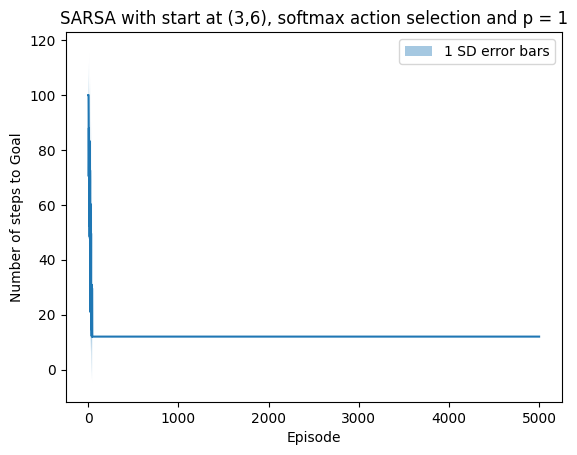

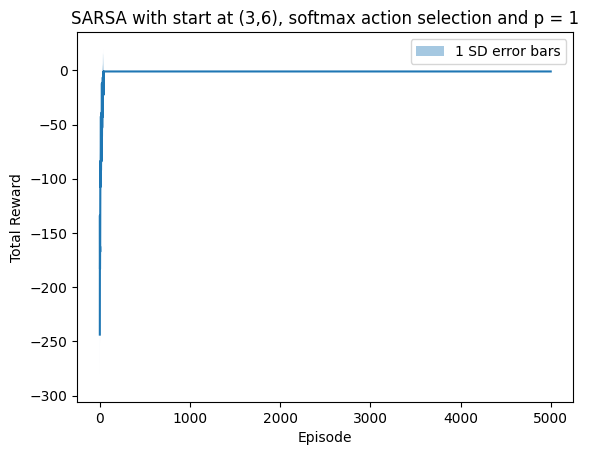

In [108]:
# Visualizing individual metrics vs episode count (averaged across 5 runs)

plt.figure()
plt.plot(steps_avgs)
# plotting 1 standard deviation error bar for each episode
plt.fill_between(np.array(range(5000)), steps_avgs - steps_std, steps_avgs + steps_std, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.title(f"SARSA with start at ({xval},{yval}), {polcy} action selection and p = 1")
plt.legend()
plt.savefig(f"sarsa_{strt}_{polcy}_1_steps")
plt.show()

plt.figure()
plt.plot(reward_avgs)
# plotting 1 standard deviation error bar for each episode
plt.fill_between(np.array(range(5000)), reward_avgs - reward_std, reward_avgs + reward_std, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f"SARSA with start at ({xval},{yval}), {polcy} action selection and p = 1")
plt.legend()
plt.savefig(f"sarsa_{strt}_{polcy}_1_reward")
plt.show()

In [109]:
# Function for plotting Heatmap of Q values, averaged over 5 runs

def plot_Q(Q, message = "Q plot"):

    plt.figure(figsize=(10,10))
    plt.title('Heatmap of Q values')
    Q = Q.reshape(10,10,4)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.savefig(f"sarsa_{strt}_{polcy}_1_Q")
    plt.show()

In [110]:
# Function for plotting Heatmap of Number of Visits to each state, averaged over 5 runs

def plot_visit(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title('Heatmap of State Visits')
    Q = Q.reshape(10,10)
    plt.pcolor(Q, edgecolors='k', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.savefig(f"sarsa_{strt}_{polcy}_1_visit")
    plt.show()

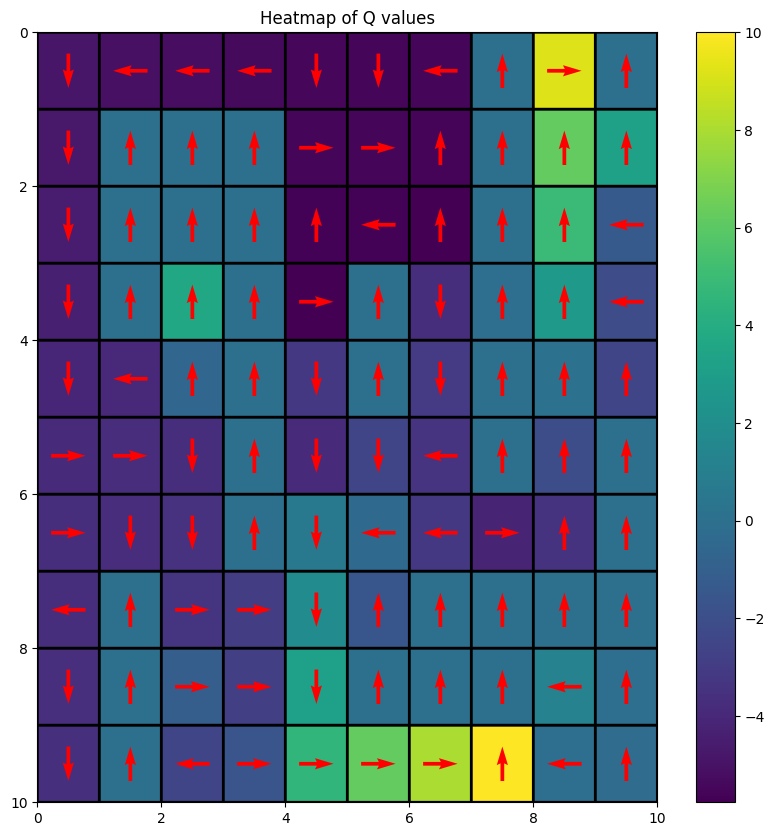

In [111]:
# Plotting Average Q values
plot_Q(Q_avgs, message = "Q plot")

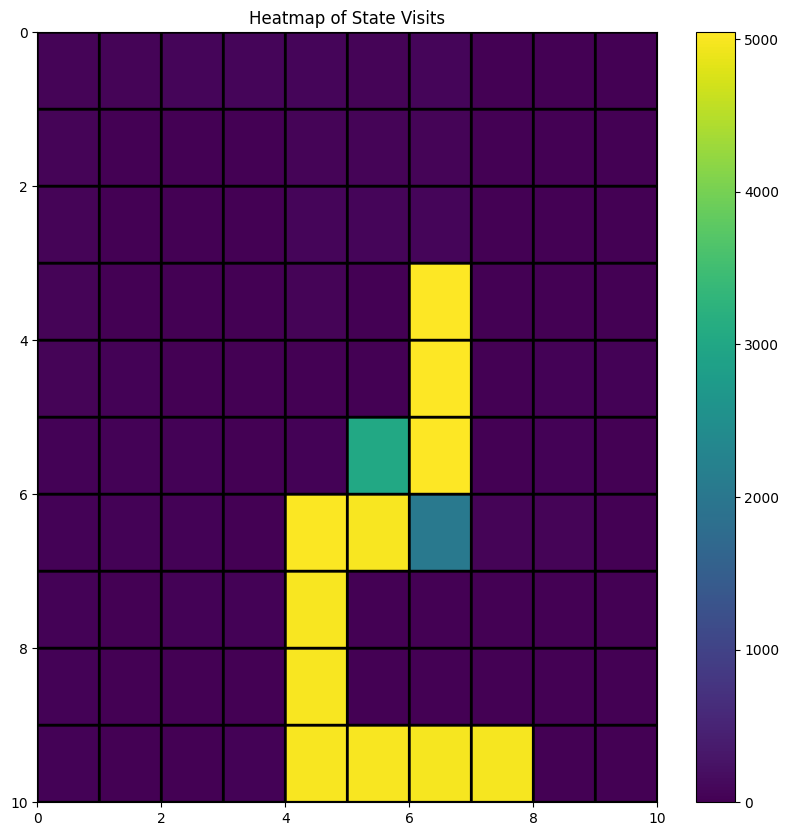

In [112]:
# Plotting average state visits for each state
plot_visit(visit_avgs, message = "Visit plot")

# Q Learning
Update Equation: 
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

In [32]:
# initialize Q-value and number of episodes
Q = np.zeros((100, 4))
episodes = 5000

In [33]:
print_freq = 100

# Q Learning Algorithm
def qlearning(env, Q, gamma = 0.9, alpha = 0.5, epsilon = 0.1, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    visit = np.zeros(100)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, epsilon)
        done = False
        while not done:
            state_next, reward = env.step(state, action)
            action_next = choose_action(Q, state_next, epsilon)
            done = state_next in env.goal_states_seq
            # Update equation for Q Learning
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * max(Q[state_next, :]) - Q[state, action])                       
            tot_reward += reward
            steps += 1
            visit[state] += 1
            # Terminate episode if number of steps exceeds 100
            done = True if steps >= 100 else done
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
          
    return Q, episode_rewards, steps_to_completion, visit

In [43]:
# Hyperparameters used for the Q Learning experiments in the following cells

alpha1 = 0.6
gamma1 = 1
epsilon1 = 0.001
polcy = "epsilon-greedy"
strt = 4
xval = 0
yval = 4

In [45]:
num_expts = 5
reward_avgs, steps_avgs = [], []
Q_avgs = []
visit_avgs = []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((100, 4))
    rg = np.random.RandomState(i)
    # Running Q Learning and storing metrics
    Q, rewards, steps, visit = qlearning(env, Q, gamma = gamma1, alpha = alpha1, epsilon = epsilon1, plot_heat=False, choose_action = choose_action_epsilon)
    Q_avgs.append(Q)
    visit_avgs.append(visit)
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    
reward_avgs = np.array(reward_avgs)
steps_avgs = np.array(steps_avgs)
reward_std = np.std(reward_avgs, axis=0) # standard deviation of reward for each episode, used for errorbars
reward_avgs = np.mean(reward_avgs, axis=0)
steps_std = np.std(steps_avgs, axis=0) # standard deviation of number of steps for each episode, used for errorbars
steps_avgs = np.mean(steps_avgs, axis=0)
Q_avgs = np.mean(Q_avgs, axis=0)
visit_avgs = np.mean(visit_avgs, axis=0)

Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1114.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:03<00:00, 1563.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:03<00:00, 1371.04it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:03<00:00, 1456.48it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:03<00:00, 1497.61it/s]


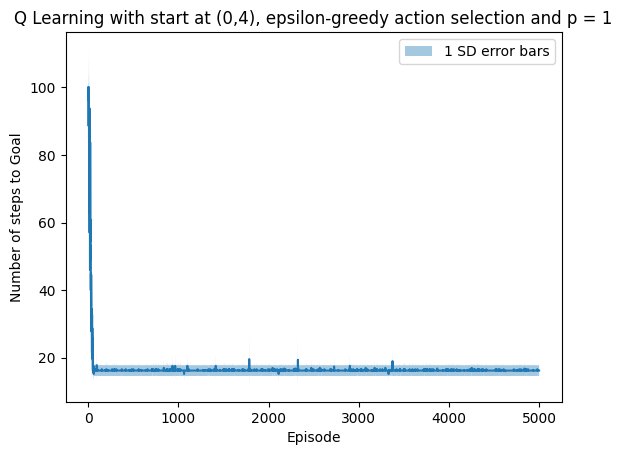

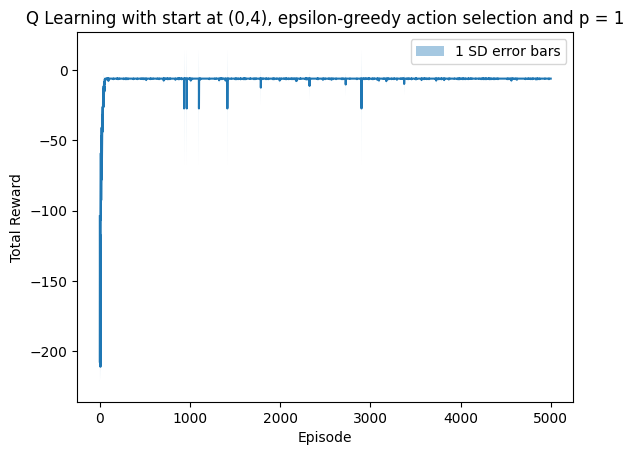

In [47]:
# Visualizing individual metrics vs episode count (averaged across multiple run(s))

plt.figure()
plt.plot(steps_avgs)
# Plotting 1 standard deviation error bar for each episode
plt.fill_between(np.array(range(5000)), steps_avgs - steps_std, steps_avgs + steps_std, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.title(f"Q Learning with start at ({xval},{yval}), {polcy} action selection and p = 1")
plt.legend()
plt.savefig(f"qlearn_{strt}_{polcy}_1_steps")
plt.show()

plt.figure()
plt.plot(reward_avgs)
# Plotting 1 standard deviation error bar for each episode
plt.fill_between(np.array(range(5000)), reward_avgs - reward_std, reward_avgs + reward_std, alpha=0.4, label='1 SD error bars')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f"Q Learning with start at ({xval},{yval}), {polcy} action selection and p = 1")
plt.legend()
plt.savefig(f"qlearn_{strt}_{polcy}_1_reward")
plt.show()

In [48]:
# Function for plotting Heatmap of Q values, averaged over 5 runs

def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title('Heatmap of Q Values')
    Q = Q.reshape(10,10,4)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.savefig(f"qlearn_{strt}_{polcy}_1_Q")
    plt.show()

In [49]:
# Function for plotting Heatmap of State Visits, averaged over 5 runs

def plot_visit(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title('Heatmap of State Visits')
    Q = Q.reshape(10,10)
    plt.pcolor(Q, edgecolors='k', linewidths=2)
    plt.gca().invert_yaxis()
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.savefig(f"qlearn_{strt}_{polcy}_1_visit")
    plt.show()

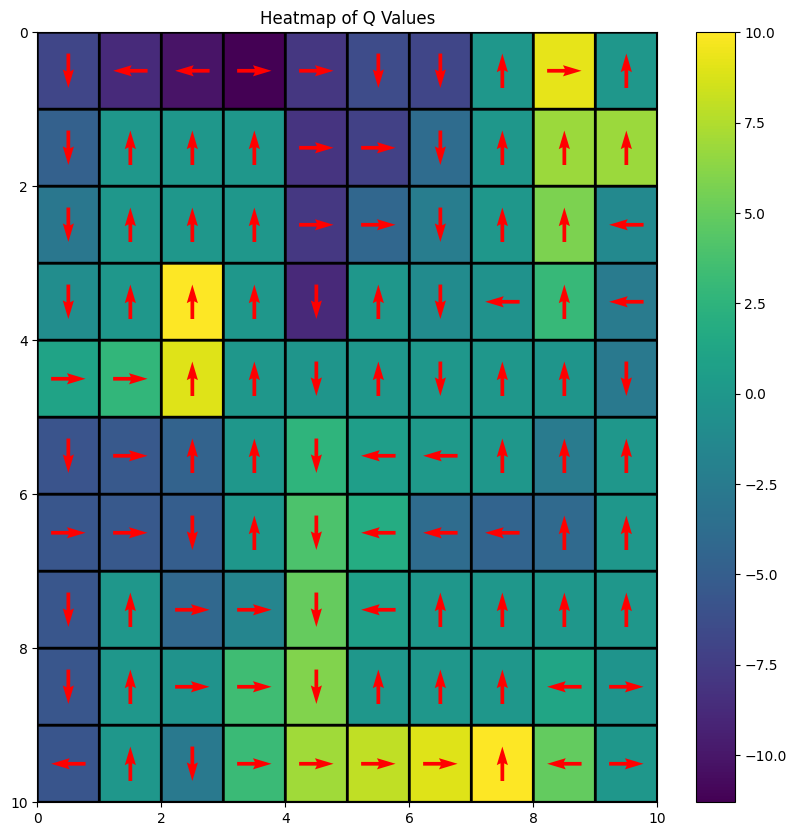

In [50]:
# Plotting average Q Values
plot_Q(Q_avgs, message = "Q plot")

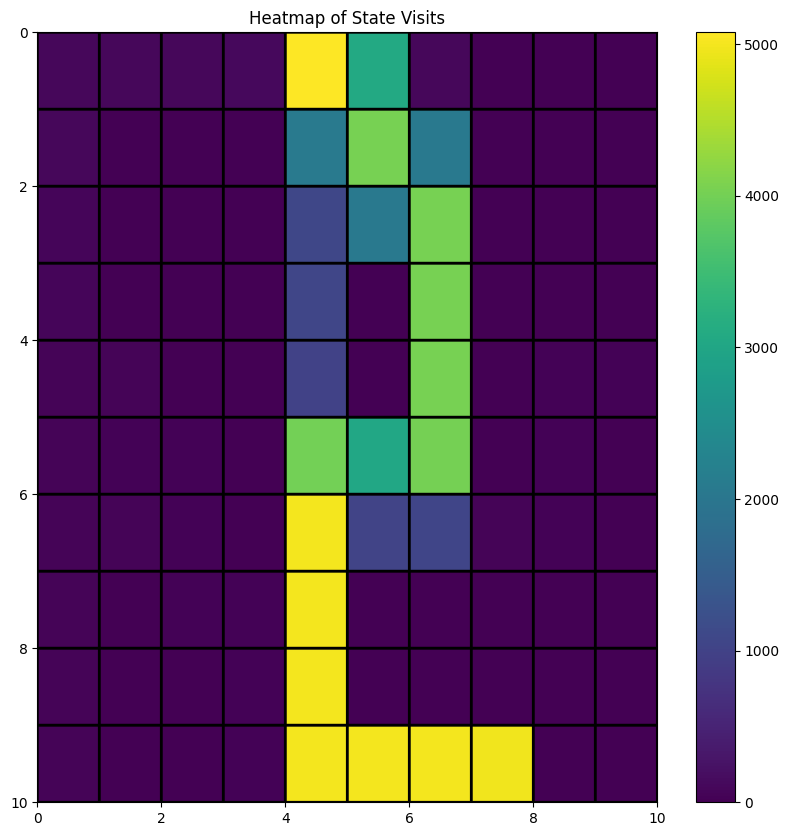

In [51]:
# Plotting average state visits for each states
plot_visit(visit_avgs, message = "Visit plot")

# Data Collection

In this section, we implemented SARSA and Q Learning again for hyperparameter tuning. We perform a grid search over hyperparameters ($\tau$/$\epsilon$, $\alpha$, $\gamma$), to find the optimal set of values for different experiments being performed.

## Imports

In [12]:
import pandas as pd

In [13]:
# Hyperparameters for experiments below
start_test = 36
wind_test = False
prob = 1

## SARSA Softmax

In [14]:
sarsa_softmax_dict = {'tau':[], 'alpha':[], 'gamma':[], 'reward':[], 'steps':[]}

In [ ]:
# Running experiments with different hyperparameters
hyperparameters = {'tau': [0.01, 0.1, 1, 10], 'alpha': [0.4, 0.5, 0.6], 'gamma': [0.7, 0.8, 0.9, 1]}
counter = 1

for tau in hyperparameters['tau']:
    for alpha in hyperparameters['alpha']:
        for gamma in hyperparameters['gamma']:
            num_expts = 5
            reward_avgs, steps_avgs = [], []
            Q_avgs = []
            visit_avgs = []
            print(f"Value Set number: {counter}")
            counter += 1
            for i in range(num_expts):
                print("Experiment: %d"%(i+1))
                Q = np.zeros((100, 4))
                rg = np.random.RandomState(i)

                # Running sarsa, storing metrics
                Q, rewards, steps, visit = sarsa(env, Q, gamma = gamma, alpha = alpha, epsilon = tau, plot_heat=False, choose_action = choose_action_softmax)
                Q_avgs.append(Q)
                visit_avgs.append(visit)
                reward_avgs.append(rewards)
                steps_avgs.append(steps)
                
            reward_avgs = np.array(reward_avgs)
            steps_avgs = np.array(steps_avgs)
            reward_avgs = np.mean(reward_avgs, axis=0)
            steps_avgs = np.mean(steps_avgs, axis=0)
            Q_avgs = np.mean(Q_avgs, axis=0)
            visit_avgs = np.mean(visit_avgs, axis=0)
            sarsa_softmax_dict['tau'].append(tau)
            sarsa_softmax_dict['alpha'].append(alpha)
            sarsa_softmax_dict['gamma'].append(gamma)
            sarsa_softmax_dict['reward'].append(np.mean(reward_avgs))
            sarsa_softmax_dict['steps'].append(np.mean(steps_avgs))


In [16]:
df_sarsa_softmax = pd.DataFrame(sarsa_softmax_dict)

In [17]:
df_sarsa_softmax.to_csv(f'sarsa_softmax_start_{start_test}_wind_{wind_test}_p_{prob}.csv')

## SARSA $\epsilon$ greedy

In [18]:
sarsa_greedy_dict = {'epsilon':[], 'alpha':[], 'gamma':[], 'reward':[], 'steps':[]}

In [ ]:
# Running experiments with different hyperparameters 

hyperparameters = {'epsilon': [0.001, 0.01, 0.1, 0.5, 0.75], 'alpha': [0.4, 0.5, 0.6], 'gamma': [0.7, 0.8, 0.9, 1]}
counter = 1

for epsilon in hyperparameters['epsilon']:
    for alpha in hyperparameters['alpha']:
        for gamma in hyperparameters['gamma']:
            num_expts = 5
            reward_avgs, steps_avgs = [], []
            Q_avgs = []
            visit_avgs = []
            print(f"Value Set number: {counter}")
            counter += 1
            for i in range(num_expts):
                print("Experiment: %d"%(i+1))
                Q = np.zeros((100, 4))
                rg = np.random.RandomState(i)

                # TODO: run sarsa, store metrics
                Q, rewards, steps, visit = sarsa(env, Q, gamma = gamma, alpha = alpha, epsilon = epsilon, plot_heat=False, choose_action = choose_action_epsilon)
                Q_avgs.append(Q)
                visit_avgs.append(visit)
                reward_avgs.append(rewards)
                steps_avgs.append(steps)
                
            reward_avgs = np.array(reward_avgs)
            steps_avgs = np.array(steps_avgs)
            reward_avgs = np.mean(reward_avgs, axis=0)
            steps_avgs = np.mean(steps_avgs, axis=0)
            Q_avgs = np.mean(Q_avgs, axis=0)
            visit_avgs = np.mean(visit_avgs, axis=0)
            sarsa_greedy_dict['epsilon'].append(epsilon)
            sarsa_greedy_dict['alpha'].append(alpha)
            sarsa_greedy_dict['gamma'].append(gamma)
            sarsa_greedy_dict['reward'].append(np.mean(reward_avgs))
            sarsa_greedy_dict['steps'].append(np.mean(steps_avgs))


In [20]:
df_sarsa_greedy = pd.DataFrame(sarsa_greedy_dict)

In [21]:
df_sarsa_greedy.to_csv(f'sarsa_greedy_start_{start_test}_wind_{wind_test}_p_{prob}.csv')

## Q Learning Softmax

In [22]:
qlearning_softmax_dict = {'tau':[], 'alpha':[], 'gamma':[], 'reward':[], 'steps':[]}

In [ ]:
# Running experiments with different hyperparameters 

hyperparameters = {'tau': [0.01, 0.1, 1, 10], 'alpha': [0.4, 0.5, 0.6], 'gamma': [0.7, 0.8, 0.9, 1]}
counter = 1

for tau in hyperparameters['tau']:
    for alpha in hyperparameters['alpha']:
        for gamma in hyperparameters['gamma']:
            num_expts = 5
            reward_avgs, steps_avgs = [], []
            Q_avgs = []
            visit_avgs = []
            print(f"Value Set number: {counter}")
            counter += 1
            for i in range(num_expts):
                print("Experiment: %d"%(i+1))
                Q = np.zeros((100, 4))
                rg = np.random.RandomState(i)

                # Running Q Learning with softmax policy and storing metrics
                Q, rewards, steps, visit = qlearning(env, Q, gamma = gamma, alpha = alpha, epsilon = tau, plot_heat=False, choose_action = choose_action_softmax)
                Q_avgs.append(Q)
                visit_avgs.append(visit)
                reward_avgs.append(rewards)
                steps_avgs.append(steps)
                
            reward_avgs = np.array(reward_avgs)
            steps_avgs = np.array(steps_avgs)
            reward_avgs = np.mean(reward_avgs, axis=0)
            steps_avgs = np.mean(steps_avgs, axis=0)
            Q_avgs = np.mean(Q_avgs, axis=0)
            visit_avgs = np.mean(visit_avgs, axis=0)
            qlearning_softmax_dict['tau'].append(tau)
            qlearning_softmax_dict['alpha'].append(alpha)
            qlearning_softmax_dict['gamma'].append(gamma)
            qlearning_softmax_dict['reward'].append(np.mean(reward_avgs))
            qlearning_softmax_dict['steps'].append(np.mean(steps_avgs))

In [24]:
df_qlearning_softmax = pd.DataFrame(qlearning_softmax_dict)

In [25]:
df_qlearning_softmax.to_csv(f'qlearning_softmax_start_{start_test}_wind_{wind_test}_p_{prob}.csv')

## Q Learning $\epsilon$ greedy

In [26]:
qlearning_greedy_dict = {'epsilon':[], 'alpha':[], 'gamma':[], 'reward':[], 'steps':[]}

In [ ]:
# Running experiments with different hyperparameters 

hyperparameters = {'epsilon': [0.001, 0.01, 0.1, 0.5, 0.75], 'alpha': [0.4, 0.5, 0.6], 'gamma': [0.7, 0.8, 0.9, 1]}
counter = 1

for epsilon in hyperparameters['epsilon']:
    for alpha in hyperparameters['alpha']:
        for gamma in hyperparameters['gamma']:
            num_expts = 5
            reward_avgs, steps_avgs = [], []
            Q_avgs = []
            visit_avgs = []
            print(f"Value Set number: {counter}")
            counter += 1
            for i in range(num_expts):
                print("Experiment: %d"%(i+1))
                Q = np.zeros((100, 4))
                rg = np.random.RandomState(i)

                # Running Q Learning with epsilon greedy and storing metrics
                Q, rewards, steps, visit = qlearning(env, Q, gamma = gamma, alpha = alpha, epsilon = epsilon, plot_heat=False, choose_action = choose_action_epsilon)
                Q_avgs.append(Q)
                visit_avgs.append(visit)
                reward_avgs.append(rewards)
                steps_avgs.append(steps)
                
            reward_avgs = np.array(reward_avgs)
            steps_avgs = np.array(steps_avgs)
            reward_avgs = np.mean(reward_avgs, axis=0)
            steps_avgs = np.mean(steps_avgs, axis=0)
            Q_avgs = np.mean(Q_avgs, axis=0)
            visit_avgs = np.mean(visit_avgs, axis=0)
            qlearning_greedy_dict['epsilon'].append(epsilon)
            qlearning_greedy_dict['alpha'].append(alpha)
            qlearning_greedy_dict['gamma'].append(gamma)
            qlearning_greedy_dict['reward'].append(np.mean(reward_avgs))
            qlearning_greedy_dict['steps'].append(np.mean(steps_avgs))

In [28]:
df_qlearning_greedy = pd.DataFrame(qlearning_greedy_dict)

In [29]:
df_qlearning_greedy.to_csv(f'qlearning_greedy_start_{start_test}_wind_{wind_test}_p_{prob}.csv')